In [2]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import matplotlib.tri as tri
from scipy.interpolate import griddata
from scipy import interpolate

In [3]:
######################## define constants etc. ############################### 

workPath = '/n/holyscratch01/dvorkin_lab/Users/tianliwang/'
#workPath = '/Users/Ed/Desktop/cosm_prjt/'

n_cosmo = 90

Om_d = 0.311  # this is one of the cosmos we used for training and predictions
si_d = 0.789

In [4]:
data = np.genfromtxt(workPath+'fullNet_testing_shuffle.dat', names=True, dtype=None)

In [5]:
Om_pred = data['Om_pred']
si_pred = data['si_pred']
Om_expect = data['Om_expect']
si_expect = data['si_expect']

# split the array into small arrays each corresponding the data from one cosmology (ex. array[0] is an array of all values in one cosmo)
Om_expect_split = np.array_split(Om_expect, n_cosmo)
Om_pred_split = np.array_split(Om_pred, n_cosmo)
si_expect_split = np.array_split(si_expect, n_cosmo)
si_pred_split = np.array_split(si_pred, n_cosmo)

In [9]:
######################## calculate P(d|theta) for the network predictions ###############################

# calculate cov matrices and put in cov_list; cov_list[i] is the cov matrix of the (i+1)-th cosmo
#cov_list = [np.cov([Om_pred_split[i], si_pred_split[i]]) for i in range(n_cosmo)]
#cov_list = np.array(cov_list)
#cov_list = (len(Om_pred_split[0])-1)/(len(Om_pred_split[0])-2-2) * cov_list  # de-bias

# calculate cov matrices and put in cov_list; cov_list[i] is the cov matrix of the (i+1)-th cosmo
cov_list = [] 
covinv_list = []

# get cov and inverse cov matrices 
for i in range(n_cosmo): 
    cov = np.cov([Om_pred_split[i], si_pred_split[i]])
    cov_list.append(cov)
    covinv_list.append(np.linalg.inv(cov))
    
cov_list = np.array(cov_list)
covinv_list = (len(Om_pred_split[0])-2-2)/(len(Om_pred_split[0])-1)*np.array(covinv_list)  # de-bias the inverse cov matrix

covdet_list = np.linalg.det(cov_list)


# calculate mean and put in mean_list; mean_list[i] is the mean [Om, si] of the (i+1)-th cosmo
Om_mean_list = np.mean(Om_pred_split, axis=1)
si_mean_list = np.mean(si_pred_split, axis=1)
#Om_mean_list = [np.mean(Om_pred_split[i]) for i in range(n_cosmo)]
#si_mean_list = [np.mean(si_pred_split[i]) for i in range(n_cosmo)]
mean_list = np.transpose([Om_mean_list, si_mean_list])

# true omegas and sigmas for each simulation 
Om_expect_list = np.array(Om_expect_split)[:,0]
si_expect_list = np.array(si_expect_split)[:,0]

# calculate P at each point (Om, si)
d = np.array([Om_d, si_d])
#P0 = multivariate_normal.pdf(mean_list[0], mean = d, cov = cov_list[0]); P0
#P0 = multivariate_normal.pdf(d, mean = d, cov = cov_list[0]); P0
P = [multivariate_normal.pdf(mean_list[i], mean = d, cov = cov_list[i]) for i in range(n_cosmo)]
P = np.array(P)

In [10]:
# Linear interpolation on a grid defined by (xi, yi)
ngrid = 50
xi = np.linspace(0.15, 0.5, ngrid)
yi = np.linspace(0.55, 1.15, ngrid)

triang = tri.Triangulation(mean_list[:,0], mean_list[:,1])
interpolator = tri.LinearTriInterpolator(triang, P)
Xi, Yi = np.meshgrid(xi, yi)
Pi = interpolator(Xi, Yi)

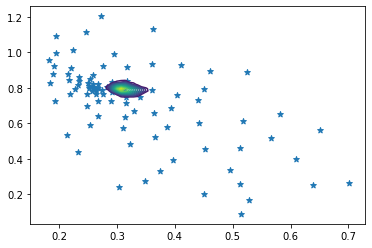

In [11]:
plt.scatter(Om_expect_list, si_expect_list, marker='*')
plt.contour(xi, yi, Pi, levels=15)
#plt.plot(Om_expect_split, si_expect_split,'.')

In [12]:
#### Another method 

# define inputs for griddata function calls 
points = np.array([Om_mean_list, si_mean_list]).T    # dimension: # grid pts X # axese 

Xi, Yi = np.array(np.meshgrid(xi, yi))
grid = np.array([np.ndarray.flatten(Xi), np.ndarray.flatten(Yi)]).T

In [13]:
Oms_interp = griddata(points, Om_mean_list, grid, method='linear')
sis_interp = griddata(points, si_mean_list, grid, method='linear')
covdet_interp = griddata(points, covdet_list, grid, method='linear')
covinv_interp = griddata(points, covinv_list, grid, method='linear')

In [14]:
# calculate the Ps from interpolated values 
means_interp = np.transpose([Oms_interp, sis_interp])


# get the exponents in the Ps
exponents = [] 

for i in range(len(means_interp)): 
    vec_temp = d - means_interp[i]
    exponents.append(-0.5*np.dot(vec_temp, np.dot(covinv_interp[i],vec_temp.T))) 
    
Ps_interp = 1.0/(covdet_interp**0.5)*np.exp(exponents)   # the prob distribution 

(0.5, 1.2)

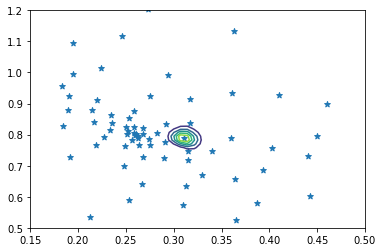

In [16]:
plt.scatter(Om_expect_list, si_expect_list, marker='*')
plt.contour(xi, yi, np.reshape(Ps_interp, (ngrid, ngrid)), levels=5)
plt.xlim(0.15, 0.5)
plt.ylim(0.5, 1.2)

## Some testing:

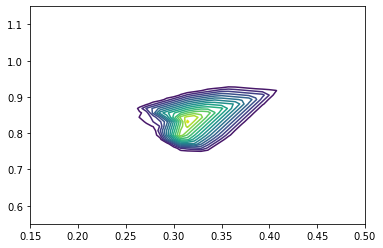

In [23]:
# this plot is for d = (0.309, 0.816) like in the paper, just for our reference
plt.contour(xi, yi, Pi, levels=15)

Very sharply peaked cuz var is small:

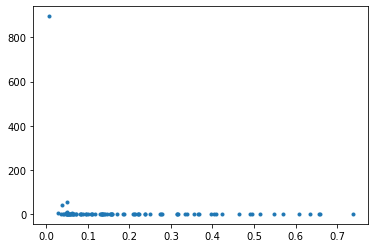

In [34]:
# try plotting P against the distance of the points to d to see how fast P drops going away from the center d:
rr = [np.linalg.norm(mean_list[i] - d) for i in range(n_cosmo)]
plt.plot(rr,P,'.')